In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./reviews.csv")

In [3]:
df.head()

,feature_id,description,lon,reviewer,review_rating,restaurant_name,image_name,city_name,review_date,image_path,reviewer_id,country_name,num_reviews,image_label,lat,pred_lat,pred_lon,spherical_distance
0,0x3e2f030b790b8bf1:0x74edaa5821a6451,"The mood, food and service in this restaurant ...",46.704888,Alain Dibo,5,MYAZU Riyadh,0x3e2f030b790b8bf1_0x74edaa5821a6451_107094518...,Riyadh,4 months ago,./images/food/0x3e2f030b790b8bf1_0x74edaa5821a...,1.070945e+20,Saudi Arabia,115,food,24.699998,38.404438,-122.364983,12906.263204
1,0x3e2f030b790b8bf1:0x74edaa5821a6451,"The mood, food and service in this restaurant ...",46.704888,Alain Dibo,5,MYAZU Riyadh,0x3e2f030b790b8bf1_0x74edaa5821a6451_107094518...,Riyadh,4 months ago,./images/food/0x3e2f030b790b8bf1_0x74edaa5821a...,1.070945e+20,Saudi Arabia,115,food,24.699998,21.310946,-157.861160,14251.136441
2,0x3e2f030b790b8bf1:0x74edaa5821a6451,"The mood, food and service in this restaurant ...",46.704888,Alain Dibo,5,MYAZU Riyadh,0x3e2f030b790b8bf1_0x74edaa5821a6451_107094518...,Riyadh,4 months ago,./images/food/0x3e2f030b790b8bf1_0x74edaa5821a...,1.070945e+20,Saudi Arabia,115,food,24.699998,22.282267,114.154984,6811.854952
3,0x3e2f030b790b8bf1:0x74edaa5821a6451,"This restaurant may not fit everyone’s budget,...",46.704888,Zee B.,5,MYAZU Riyadh,0x3e2f030b790b8bf1_0x74edaa5821a6451_106250183...,Riyadh,a month ago,./images/food/0x3e2f030b790b8bf1_0x74edaa5821a...,1.062502e+20,Saudi Arabia,44,food,24.699998,1.304427,103.832100,6653.282315
4,0x3e2f030b790b8bf1:0x74edaa5821a6451,"This restaurant may not fit everyone’s budget,...",46.704888,Zee B.,5,MYAZU Riyadh,0x3e2f030b790b8bf1_0x74edaa5821a6451_106250183...,Riyadh,a month ago,./images/indoors/0x3e2f030b790b8bf1_0x74edaa58...,1.062502e+20,Saudi Arabia,44,indoor,24.699998,34.067379,-118.402229,13293.720163


In [5]:
from geoclip.GeoCLIP import GeoCLIP

In [6]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [7]:
model = GeoCLIP(from_pretrained=True)

In [8]:
print(model)

GeoCLIP(
  (image_encoder): ImageEncoder(
    (CLIP): CLIPModel(
      (text_model): CLIPTextTransformer(
        (embeddings): CLIPTextEmbeddings(
          (token_embedding): Embedding(49408, 768)
          (position_embedding): Embedding(77, 768)
        )
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-11): 12 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): CLIPMLP(
                (activation_fn): QuickGELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
            

In [9]:
image_encoder = model.image_encoder

In [10]:
from PIL import Image

In [11]:
test_image_path = df['image_path'][0]

In [ ]:
test_image = Image.open(test_image_path)

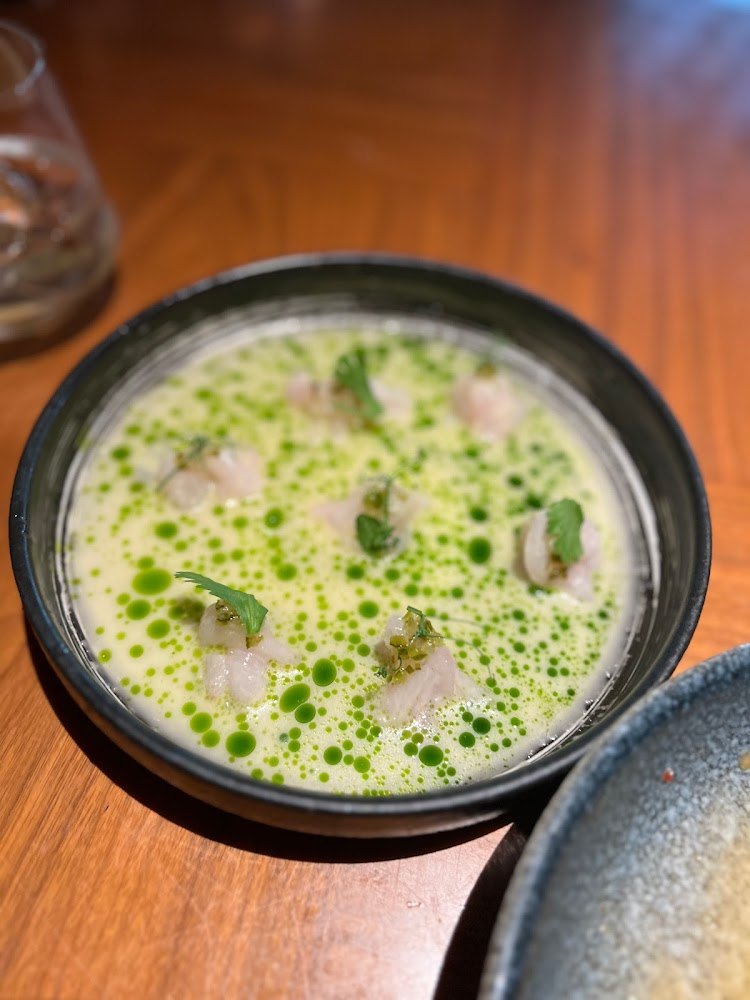

In [12]:
test_image

In [13]:
test_image_processed = image_encoder.preprocess_image(test_image)

In [14]:
test_image_embedding = image_encoder(test_image_processed)

In [15]:
test_image_embedding.size()

torch.Size([1, 512])

In [13]:
import numpy as np

In [14]:
import torch
from tqdm import tqdm

In [15]:
# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
image_encoder = image_encoder.to(device)  # Move the encoder to GPU

In [20]:
# Function to load and encode a single image
def load_and_encode_image(image_path):
    test_image = Image.open(image_path)
    test_image_processed = image_encoder.preprocess_image(test_image).to(device)
    with torch.no_grad():
        test_image_embedding = image_encoder(test_image_processed)
    return test_image_embedding.cpu().numpy()

In [21]:
# Function to save embeddings
def save_embeddings(embeddings, file_path):
    np.save(file_path, embeddings)
    print(f"Embeddings saved to {file_path}")

In [22]:
# Function to load embeddings
def load_embeddings(file_path):
    embeddings = np.load(file_path)
    print(f"Embeddings loaded from {file_path}")
    return embeddings

In [23]:
import os

In [24]:
embeddings_file = './image_embeddings.npy'

# Check if embeddings file exists
if os.path.exists(embeddings_file):
    print("Found existing embeddings. Loading...")
    embeddings = load_embeddings(embeddings_file)
else:
    print("No existing embeddings found. Generating new embeddings...")
    embeddings = []
    for image_path in tqdm(df['image_path']):
        embedding = load_and_encode_image(image_path)
        embeddings.append(embedding)
    # Convert embeddings to a numpy array
    embeddings = np.vstack(embeddings)
    save_embeddings(embeddings, embeddings_file)

Found existing embeddings. Loading...
Embeddings loaded from ./image_embeddings.npy


In [25]:
# Convert to PyTorch tensor and move to GPU
embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)

In [53]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

In [43]:
# Perform K-means clustering
print("Performing K-means clustering...")
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

Performing K-means clustering...


In [44]:
# Perform t-SNE for visualization
print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

Performing t-SNE dimensionality reduction...


In [45]:
# Visualize the clusters
print("Generating visualization...")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Image Clusters Visualization')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.savefig('image_clusters_visualization.png')
plt.close()

Generating visualization...


In [49]:
# Function to get representative images for each cluster
def get_representative_images(cluster, n=5, seed=None):
    if seed is not None:
        random.seed(seed)
    cluster_indices = np.where(cluster_labels == cluster)[0]
    selected_indices = random.sample(list(cluster_indices), min(n, len(cluster_indices)))
    return df.iloc[selected_indices]['image_path'].tolist()

In [50]:
# Function to display representative images
def display_cluster_images(cluster, n=5, seed=None):
    rep_images = get_representative_images(cluster, n, seed)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    fig.suptitle(f'Representative Images for Cluster {cluster}', fontsize=16)
    
    for ax, img_path in zip(axes, rep_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(img_path), fontsize=8)
    
    plt.tight_layout()
    plt.show()  # Display in notebook
    plt.savefig(f'cluster_{cluster}_representative_images.png')
    plt.close()

In [51]:
# Function to display images for all clusters
def display_all_clusters(n_images=5, seed=None):
    for i in range(n_clusters):
        print(f"Cluster {i}:")
        display_cluster_images(i, n_images, seed)


In [93]:
# Convert alphanumeric labels to numeric labels
label_mapping = {chr(i+ord('A')): i for i in range(n_clusters)}  # 0 -> A, 1 -> B, 2 -> C, etc.
cluster_labels = np.array([label_mapping[label] for label in cluster_labels])

Cluster 0:


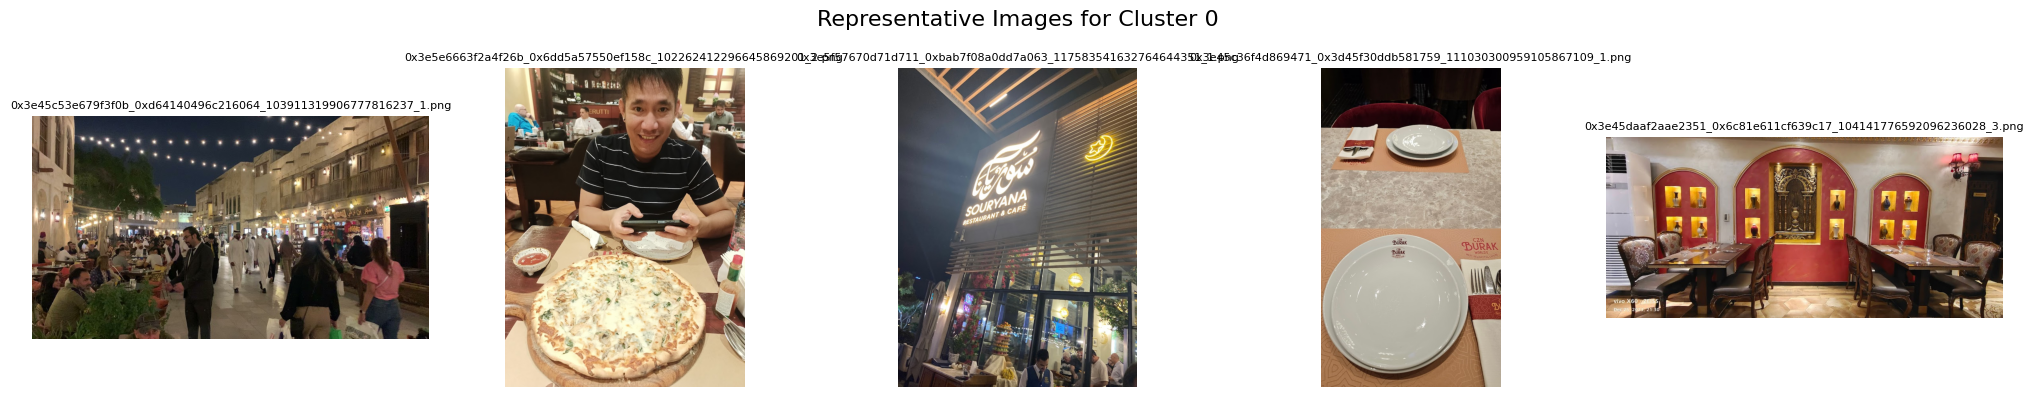

Cluster 1:


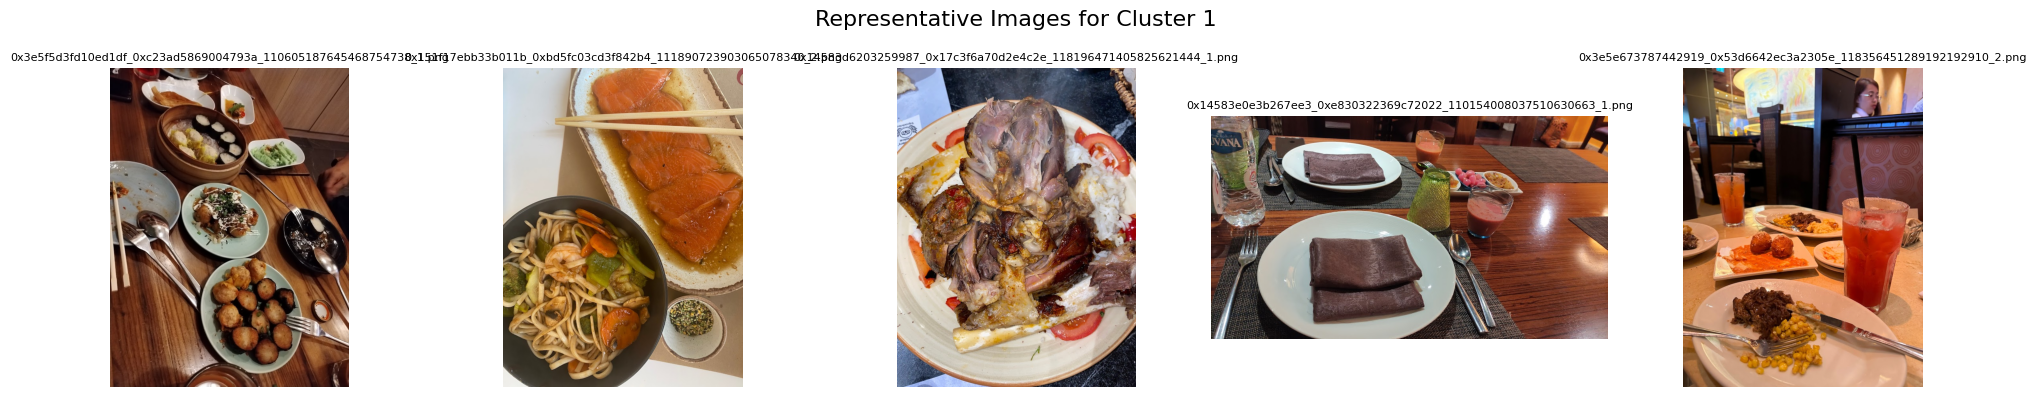

In [97]:
display_all_clusters(n_images=5)

In [91]:
# Convert numeric labels to alphabetic labels
label_mapping = {i: chr(65 + i) for i in range(n_clusters)}  # 0 -> A, 1 -> B, 2 -> C, etc.
cluster_labels = np.array([label_mapping[label] for label in cluster_labels])

In [92]:
# Save cluster assignments
df['cluster'] = cluster_labels
df.to_csv('clustered_images.csv', index=False)

print("Clustering complete. Results saved to 'clustered_images.csv' and 'image_clusters_visualization.png'")

Clustering complete. Results saved to 'clustered_images.csv' and 'image_clusters_visualization.png'
